# This notebook produces predictions from theory for consistency checks

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
import pyccl as ccl

from tqdm import tqdm #for timing

from IPython.display import HTML
from IPython.display import display

Last Updated: 17 July 2020

### Tasks:
* Generate cross power spectra from CCL: DONE
* Generate correlated synthetic maps using healpy with theory $C_l$s: DONE
* Study the correlation of Planck noise power spectrum with theory $C_l$s: TODO
* Calculate RCC for ELG X CMB Lensing from theory: DONE

### Tests:

* Recover $C_l$s from full-sky no noise signal maps: DONE
* Recover $C_l$s from masked-sky no noise signal maps by correcting for $f_{sky}$: DONE
* Recover $C_l$s from full-sky noised signal maps: DONE
* Recover $C_l$s from masked-sky noised signal maps: TODO
* Verify that hp.UNSEEN has no affect on $C_l$ calculations: DONE
* Recover $C_l$s from smoothed full-sky no noise signal maps: DONE
* Recover $C_l$s from smoothed masked-sky no noise signal maps: TODO
* Recover $C_l$s from smoothed masked-sky noised signal maps: TODO
* Calculate RCC for each of the prior tests and compare with theory: TODO

Binning function from Sukhdeep

In [2]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

## Section 1: Systematic Tests

### $C^{\kappa \kappa}_{l}$ from theory

In [3]:
#define cosmology Planck 2018 CMB Lensing Fiducial 1807.06210 last bullet point above Sec 2.2
cosmo = ccl.Cosmology(Omega_c = 0.268, Omega_b = 0.049,
        h = 0.670, n_s = 0.964, A_s = 2.119e-9,
        m_nu_type='list', m_nu = np.array([0, 0, 0.06]),
        transfer_function='boltzmann_camb') 

In [4]:
#define params
lmin = 100; lmax = 2048
ell = np.arange(0, lmax, 1)
fs = 18
alpha = 0.5
NSIDE = 1024
SEED = 1234

In [5]:
#calculate theoretical Cls
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb_th = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

/home/tanveer/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


### $C^{g g}_{l}$ from theory

Text(0.5, 1.0, 'dNdz from FDR')

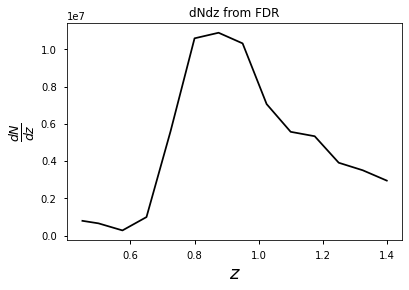

In [6]:
#read in dNdz
dNdzddeg2 = pd.read_csv("light_cones/nz_blanc+abacus.txt", sep=",")

z = dNdzddeg2['Redshift_mid']
area = dNdzddeg2['abacus_area_deg2']
dNdz = dNdzddeg2['dndz/deg^2'] * area

fs = 18

plt.plot(z, dNdz, 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz}$", fontsize = fs)
plt.title("dNdz from FDR")

In [7]:
#set constant bias
b = 1.25*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

In [8]:
#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elgl, elgl, ell)

### $C^{m m}_{l}$ from theory

In [9]:
#set constant bias
b = 1.0*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
mml = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

In [10]:
#calculate theoretical Cls
cls_mm_th = ccl.angular_cl(cosmo, mml, mml, ell)

### $C^{\kappa g}_{l}$ from theory

In [11]:
#calculate theoretical Cls
cls_cross_th = ccl.angular_cl(cosmo, elgl, cmbl, ell)

All the three power spectra together:

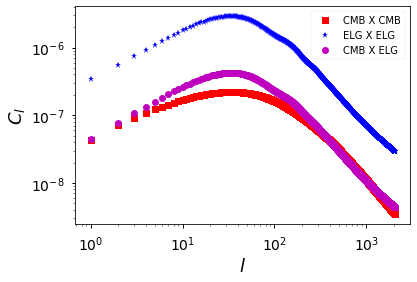

In [12]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')


plt.plot(ell, cls_cmb_th, 'rs', label = "CMB X CMB")
plt.plot(ell, cls_elg_th, 'b*', label = "ELG X ELG")
plt.plot(ell, cls_cross_th, 'mo', label = "CMB X ELG")
plt.legend(loc = 'best')

Generate binned power spectra with $100l$s per bin:

In [13]:
bins = np.arange(0, lmax+1, 100)
ELL, cLs_cmb_th = bin_mat(ell, cls_cmb_th, bins)
_, cLs_elg_th = bin_mat(ell, cls_elg_th, bins)
_, cLs_cross_th = bin_mat(ell, cls_cross_th, bins)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


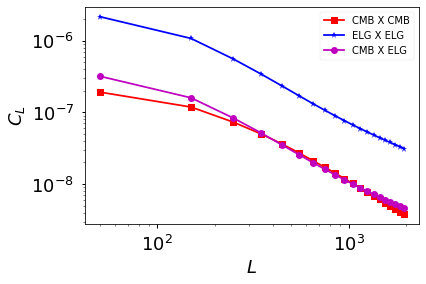

In [14]:
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.loglog(ELL, cLs_cmb_th, 'rs', ls = '-', label = "CMB X CMB")
plt.loglog(ELL, cLs_elg_th, 'b*', ls = '-', label = "ELG X ELG")
plt.loglog(ELL, cLs_cross_th, 'mo', ls = '-', label = "CMB X ELG")
plt.legend(loc = 'best')

Function to generate plots  from synthetic maps to compare against theory

In [15]:
def plot_powerspectra(cls, fields, ELL_min = lmin, ELL_max = lmax, **kwargs):
    """Calculates power spectra using anafast and produces plots against theory
    cls: list of cls to be plotted
    fields: 'gg', 'kk' or 'kg'
    ell_min: minimum ell to be plotted
    ell_max: max ell to be plotted
    label: plot legend label"""
    
    #bin cls
    
    _, cLs = bin_mat(ell, cls, bins)
    
    fltr_ELL = (ELL > ELL_min) & (ELL < ELL_max) #filter results between range
    
    if(fields == 'kk'):
        plt.loglog(ELL[fltr_ELL], cLs_cmb_th[fltr_ELL], 'rs', label = "CMB Theory")
        plt.ylabel(r"$C^{\kappa \kappa}_{L}$", fontsize = fs)
    elif(fields == 'gg'):
        plt.loglog(ELL[fltr_ELL], cLs_elg_th[fltr_ELL], "b*", label = "ELG Theory")
        plt.ylabel(r"$C^{g g}_{L}$", fontsize = fs)
    elif((fields == 'kg') | (fields == 'gk')):
        plt.loglog(ELL[fltr_ELL], cLs_cross_th[fltr_ELL], "mo", label = "CMB X ELG Theory")
        plt.ylabel(r"$C^{k g}_{L}$", fontsize = fs)
        
    plt.loglog(ELL[fltr_ELL], cLs[fltr_ELL], alpha = alpha, **kwargs)
    plt.xlabel(r"$L$", fontsize = fs)
    plt.legend(loc = 'best')
    plt.show() 
    
    if(fields == 'kk'):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_cmb_th)[fltr_ELL], "rs", ls = '-')
    elif(fields == 'gg'):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_elg_th)[fltr_ELL], "b*", ls = '-')
    elif((fields == 'kg') | (fields == 'gk')):
        plt.plot(ELL[fltr_ELL], (cLs/cLs_cross_th)[fltr_ELL], "mo", ls = '-')
        
    plt.xlabel(r"$L$", fontsize = fs)
    plt.ylabel(r"$\frac{C^{obs}_{L}}{C^{th}_{L}}$", fontsize = fs)
    plt.axhline(1)
    plt.show()

### Make synthetic maps

***Deprecated***

We are going to produce synthetic maps following Appendix of Giannantonio et al. 2008 (PhysRevD.77.123520).

Given two correlated maps $m_1$ and $m_2$, there are three power spectra $C^{11}_{l}$, $C^{12}_{l} = C^{21}_{l}$ and $C^{22}_{l}$. In this case, the coefficients of the spherical harmonics are given by:

\begin{align}
a^{1}_{lm} &= \xi_a \sqrt{C^{11}_{l}} \\
a^{2}_{lm} &= \xi_a \frac{C^{12}_{l}}{\sqrt{C^{11}_{l}}} + \xi_b \sqrt{C^{22}_{l} - \frac{\left(C^{12}_{l}\right)^2}{C^{11}_{l}}}
\end{align}

where $\xi$ is a random complex variable with mean $0$ and variance $1$, that denotes the random amplitude for a given mode. 

Now, Healpy *synfast* uses the *synalm* function to generate maps. The *synalm* function effectively does the following by taking $C_l$ as the input:

\begin{equation}
a_{lm} = \sqrt{C_l} \xi
\end{equation}

Thus, we can use this procedure to produce synthetic maps in the following way (assume $1 = \kappa and 2 = g$):

- Produce the first map, $m_1 = m_{\kappa}$ (CMB Lensing) using $C^{\kappa \kappa}_{l}$
- Produce an intermediary map, $m_p$ using $\frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$ using the **same** seed as $m_1$.
- Produce another intermediary map with a **new** seed, $m_q$ using $C^{gg}_{l} - \frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$
- Produce the second map, $m_2 = m_g$ (galaxy overdensity) using $m_g = m_p + m_q$

Limitations:
- This works for weakly correlated maps. For strongly correlated maps, the square root might give rise to errors. 
- This procedure only produces positive correlations due to the nature of synfast. 
    - If $C^{22}_{l}$ is negatively correlated, then the second map needs to be corrected by $m_2 *= -1$.
    - If $C^{22}_{l}$ is mixed, then produce intermediary maps $m_+$ and $m_-$ as $m_{+} = m_2$ and $m_{-} = -1 * m_2$ and afterwards $m_2 = m_{+} - m_{-}$.
    
    
---------
Also can do this by passing $C^{\kappa \kappa}_{l}$, $C^{\kappa g}_{l}$ and $C^{gg}_{l}$ to *synfast* and get $m_{\kappa}$ and $m_{g}$ out respectively.

**Note**: Produde maps using synfast as the previous method introdues some systematic biases in the cross power-spectra.

Generate 10 quick mocks

In [16]:
nmocks = 10 #number of mocks

#store mock data
m_k = np.zeros((nmocks, 12 * NSIDE**2))
m_g = np.zeros((nmocks, 12 * NSIDE**2))

from time import time
start_time = time()

for i in range(nmocks):
    np.random.seed(SEED + i)
    m_k[i], m_g[i] = hp.synfast((cls_cmb_th, cls_cross_th,  cls_elg_th), nside = NSIDE, pol=False, verbose=False)
    
print(f"Total time : {time() - start_time}")

Total time : 8.237334728240967


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

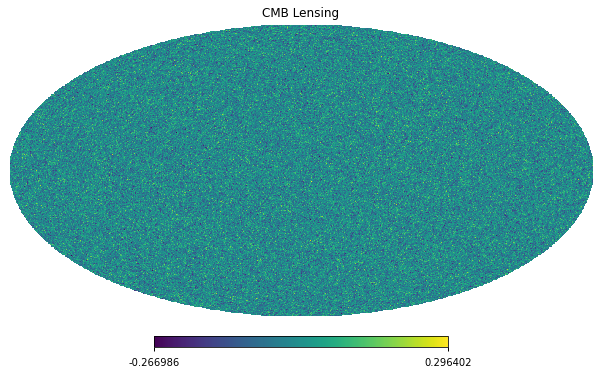

In [17]:
hp.mollview(m_k[0], title = "CMB Lensing")

In [18]:
#calculate pseudo-Cls and binned pseudo-Cls

cl_cmb_obs = np.zeros((nmocks, lmax))
cl_elg_obs = np.zeros((nmocks, lmax))
cl_cross_obs = np.zeros((nmocks, lmax))

cL_cmb_obs = np.zeros((nmocks, bins.shape[0] - 1))
cL_elg_obs = np.zeros((nmocks, bins.shape[0] - 1))
cL_cross_obs = np.zeros((nmocks, bins.shape[0] - 1))

ELL = np.zeros (bins.shape[0] - 1)

for i in tqdm(range(nmocks)):
    cl_cmb_obs[i] = hp.anafast(m_k[i], lmax = lmax - 1)
    cl_elg_obs[i] = hp.anafast(m_g[i], lmax = lmax - 1)
    cl_cross_obs[i] = hp.anafast(m_k[i], m_g[i], lmax = lmax - 1)
    
    ELL, cL_cmb_obs[i] = bin_mat(ell, cl_cmb_obs[i], bins)
    _, cL_elg_obs[i] = bin_mat(ell, cl_elg_obs[i], bins)
    _, cL_cross_obs[i] = bin_mat(ell, cl_cross_obs[i], bins)

100%|██████████| 10/10 [01:07<00:00,  6.79s/it]


Text(0.5, 1.0, '$C_{\\kappa g}$')

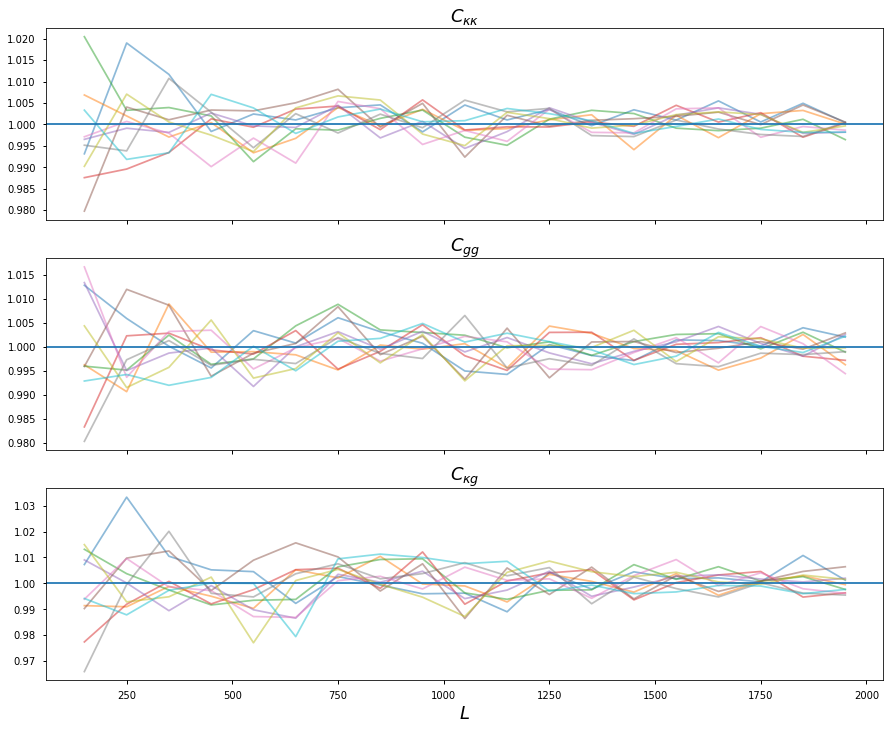

In [19]:
# Create two subplots and unpack the output array immediately
flag_clip =  ELL > 100 #choose ell modes above 100

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (15, 12))

for i in range(nmocks):
    ax1.plot(ELL[flag_clip], (cL_cmb_obs[i]/cLs_cmb_th)[flag_clip], alpha = 0.5)
    ax2.plot(ELL[flag_clip], (cL_elg_obs[i]/cLs_elg_th)[flag_clip], alpha = 0.5)
    ax3.plot(ELL[flag_clip], (cL_cross_obs[i]/cLs_cross_th)[flag_clip], alpha = 0.5)
    
ax1.axhline(1)
ax2.axhline(1)
ax3.axhline(1)
ax3.set_xlabel(r"$L$", fontsize = fs)
ax1.set_title(r"$C_{\kappa \kappa}$", fontsize = fs)
ax2.set_title(r"$C_{gg}$", fontsize = fs)
ax3.set_title(r"$C_{\kappa g}$", fontsize = fs)

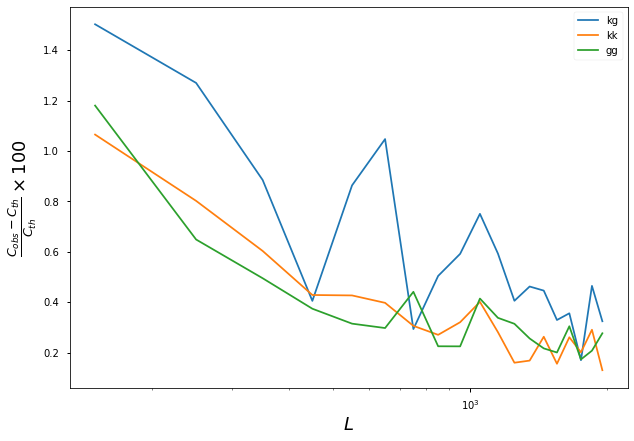

In [20]:
plt.figure(figsize=(10, 7))
plt.semilogx(ELL[flag_clip], np.std((cL_cross_obs - cLs_cross_th)/cLs_cross_th * 100, axis = 0)[flag_clip], label = 'kg')
plt.semilogx(ELL[flag_clip], np.std((cL_cmb_obs - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip], label = 'kk')
plt.semilogx(ELL[flag_clip], np.std((cL_elg_obs - cLs_elg_th)/cLs_elg_th * 100, axis = 0)[flag_clip], label = 'gg')
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{obs} - C_{th}}{C_{th}} \times 100$ ", fontsize = fs)
plt.legend(loc ='best')

In [21]:
print(np.mean(cL_cross_obs/cLs_cross_th))
print(np.std(cL_cross_obs/cLs_cross_th))

print(np.mean(cL_cmb_obs/cLs_cmb_th))
print(np.std(cL_cmb_obs/cLs_cmb_th))

1.0001618213313517
0.009072380091021279
1.0003312323657962
0.005198706215997612


***Conclusion 1: Recovered $C_l$ with Fourier noise.***

Effect of Fourier Noise is around $1 \%$ up to $l \sim 300$. Effect of cosmic variance?

#### Test 2: Add mask and calculate $\tilde{C_l}$

Add Planck lensing mask to CMB signal

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

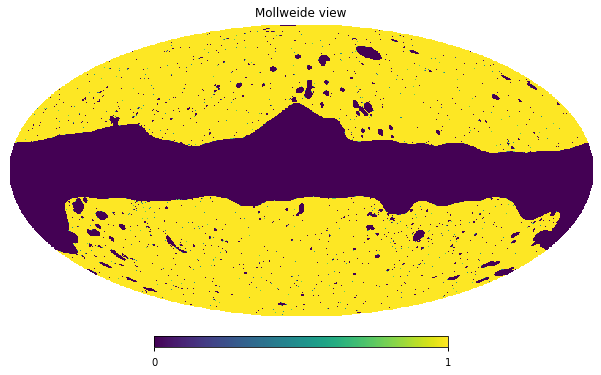

In [22]:
#Read Planck Lensing mask
lensingMask_planck = hp.fitsfunc.read_map("data/mask.fits")
lensingMask_planck = hp.ud_grade(lensingMask_planck, NSIDE)
hp.mollview(lensingMask_planck)

100%|██████████| 10/10 [00:00<00:00, 86.18it/s]


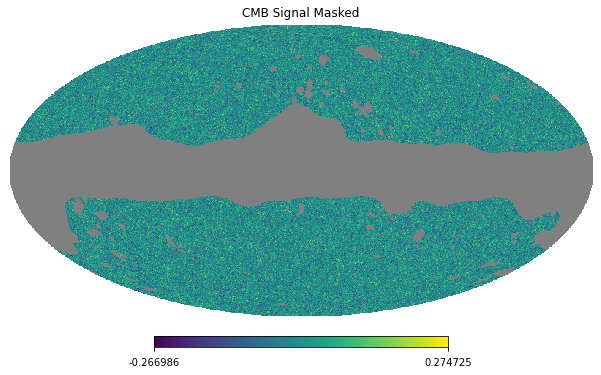

In [23]:
#Cover synthetic map with mask

m_k_masked = np.copy(m_k) #to store masked CMB lensing mocks 

for i in tqdm(range(nmocks)):
    m_k_masked[i][lensingMask_planck == 0] = hp.UNSEEN
    #m_k_masked[i].mask = np.logical_not(lensingMask_planck)
#m_k_masked = hp.ma(m_k, badval = 0)
#m_k_masked.mask = np.logical_not(lensingMask_planck)
hp.mollview(m_k_masked[0], title = "CMB Signal Masked")

Add DR8 mask to ELG signal by rotating ELG catalogue from Eq. Coord. to Gal. Coord.

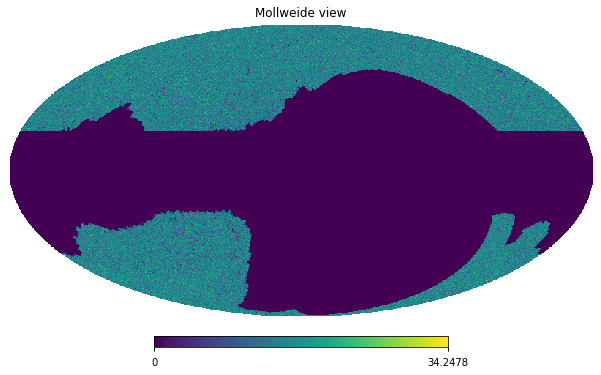

In [24]:
ranCat = np.load("data/elg_ran1024.npy") #use random ELG catalogue
#define rotator class from Eq. Coord. to Gal. Coord
r = hp.Rotator(coord=['C','G'])

ranCat_galactic = r.rotate_map_pixel(ranCat)
hp.mollview(ranCat_galactic)

In [25]:
#degrade DR8 map to remove small patches and then upgrade back to NSIDE to start making mask
ranCat_dgrade = hp.ud_grade(ranCat_galactic, 32)
ranCat_dgrade = hp.ud_grade(ranCat_dgrade, NSIDE)

m_g_masked = np.copy(m_g)

#superimpose DESI mask onto the mock map
for i in tqdm(range(nmocks)):
    m_g_masked[i][ranCat_dgrade == 0] = hp.UNSEEN

# generate mask for fsky calculation 
elg_mask = np.copy(m_g[0])
elg_mask[ranCat_dgrade == 0] = 0
elg_mask[ranCat_dgrade > 0] = 1

100%|██████████| 10/10 [00:00<00:00, 74.55it/s]


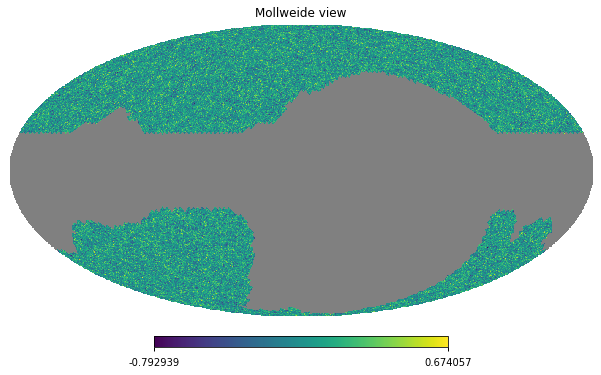

In [26]:
hp.mollview(m_g_masked[0])

In [27]:
#Calculate pseudo-Cls
cl_cmb_masked = np.zeros(cl_cmb_obs.shape)
cl_elg_masked = np.zeros(cl_cmb_obs.shape)
cl_cross_masked = np.zeros(cl_cmb_obs.shape)

cL_cmb_masked = np.zeros((nmocks, bins.shape[0] - 1))
cL_elg_masked = np.zeros((nmocks, bins.shape[0] - 1))
cL_cross_masked = np.zeros((nmocks, bins.shape[0] - 1))

for i in tqdm(range(nmocks)):
    cl_cmb_masked[i] = hp.anafast(m_k_masked[i], lmax = lmax-1)
    cl_elg_masked[i] = hp.anafast(m_g_masked[i], lmax = lmax-1)
    cl_cross_masked[i] = hp.anafast(m_k_masked[i], m_g_masked[i], lmax = lmax-1)
    
    _, cL_cmb_masked[i] = bin_mat(ell, cl_cmb_masked[i], bins)
    _, cL_elg_masked[i] = bin_mat(ell, cl_elg_masked[i], bins)
    _, cL_cross_masked[i] = bin_mat(ell, cl_cross_masked[i], bins)

100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


As expected, $\tilde{C_l}$ due to mask has lower signal expected. Need to correct for $f_{sky}.$

Correct for $f_{sky}$

In [28]:
#using boolean where Truth = observed pixel
fsky_lensing = lensingMask_planck.sum()/lensingMask_planck.size
fsky_elg = elg_mask.sum()/elg_mask.size

#Logical combine two masks to get cross-corr mask
cross_mask = np.logical_and(elg_mask, hp.ud_grade(lensingMask_planck, NSIDE))
fsky_cross = cross_mask.sum()/cross_mask.size

Text(0.5, 1.0, '$C_{\\kappa g}$')

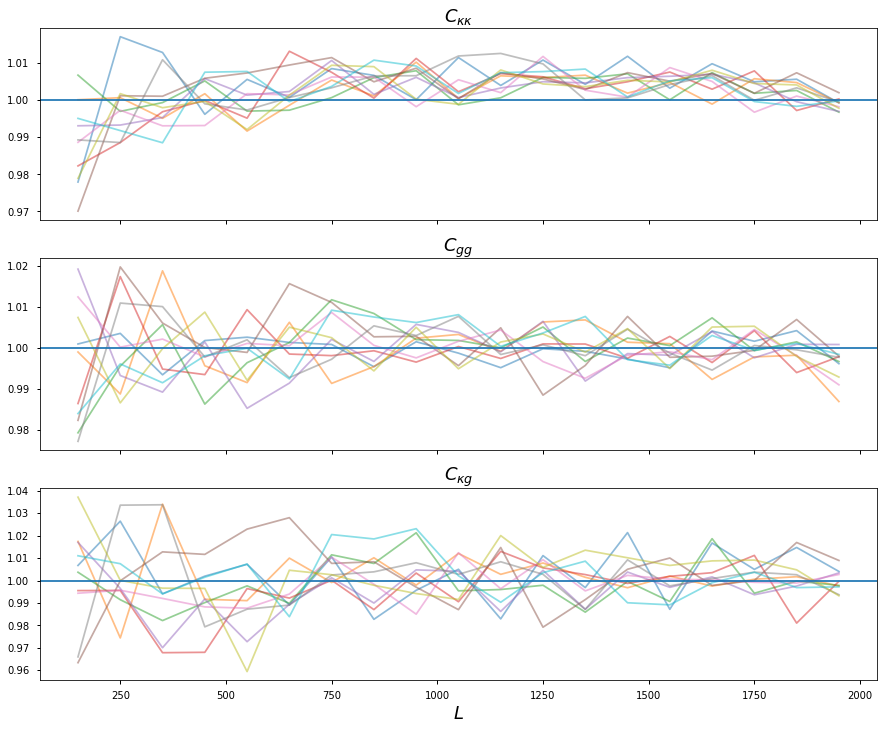

In [29]:
# Create two subplots and unpack the output array immediately
flag_clip =  ELL > 100 #choose ell modes above 100

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (15, 12))

for i in range(nmocks):
    ax1.plot(ELL[flag_clip], ((cL_cmb_masked[i]/fsky_lensing)/cLs_cmb_th)[flag_clip], alpha = 0.5)
    ax2.plot(ELL[flag_clip], ((cL_elg_masked[i]/fsky_elg)/cLs_elg_th)[flag_clip], alpha = 0.5)
    ax3.plot(ELL[flag_clip], ((cL_cross_masked[i]/fsky_cross)/cLs_cross_th)[flag_clip], alpha = 0.5)
    
ax1.axhline(1)
ax2.axhline(1)
ax3.axhline(1)
ax3.set_xlabel(r"$L$", fontsize = fs)
ax1.set_title(r"$C_{\kappa \kappa}$", fontsize = fs)
ax2.set_title(r"$C_{gg}$", fontsize = fs)
ax3.set_title(r"$C_{\kappa g}$", fontsize = fs)

Check difference between $C_{l}$ and $\tilde{C_l}$ where $\tilde{C_l}$ is corrected for $f_{sky}$

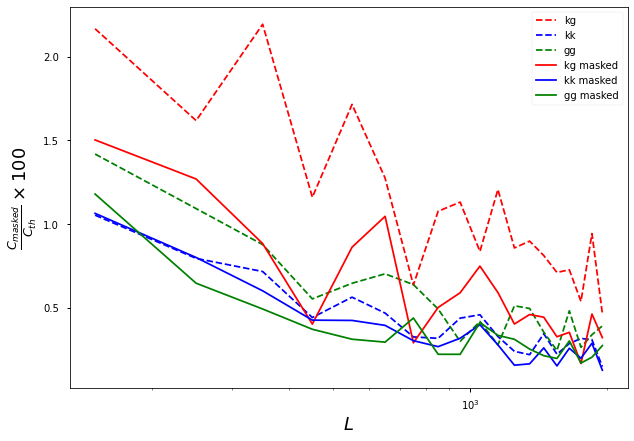

In [30]:
plt.figure(figsize=(10, 7))
plt.semilogx(ELL[flag_clip], np.std(((cL_cross_masked/fsky_cross) - cLs_cross_th)/cLs_cross_th * 100, axis = 0)[flag_clip], label = 'kg', ls = '--', c = 'r')
plt.semilogx(ELL[flag_clip], np.std(((cL_cmb_masked/fsky_lensing) - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip], label = 'kk', ls = '--', c = 'b')
plt.semilogx(ELL[flag_clip], np.std(((cL_elg_masked/fsky_elg) - cLs_elg_th)/cLs_elg_th * 100, axis = 0)[flag_clip], label = 'gg', ls = '--', c = 'g')

#Fourier noise only 
plt.semilogx(ELL[flag_clip], np.std((cL_cross_obs - cLs_cross_th)/cLs_cross_th * 100, axis = 0)[flag_clip], label = 'kg masked', c = 'r')
plt.semilogx(ELL[flag_clip], np.std((cL_cmb_obs - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip], label = 'kk masked', c = 'b')
plt.semilogx(ELL[flag_clip], np.std((cL_elg_obs - cLs_elg_th)/cLs_elg_th * 100, axis = 0)[flag_clip], label = 'gg masked', c = 'g')

plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{masked}}{C_{th}} \times 100$ ", fontsize = fs)
plt.legend(loc ='best')

In [31]:
"""tmp = (1 - (cl_cmb_masked/fsky_lensing)/cls_cmb_th)[ell > 100]
print(f"CMB Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_elg_masked/fsky_elg)/cls_elg_th)[ell > 100]
print(f"ELG Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_cross_masked/fsky_cross)/cls_cross_th)[ell > 100]
print(f"Cross Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")"""

'tmp = (1 - (cl_cmb_masked/fsky_lensing)/cls_cmb_th)[ell > 100]\nprint(f"CMB Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")\ntmp = (1 - (cl_elg_masked/fsky_elg)/cls_elg_th)[ell > 100]\nprint(f"ELG Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")\ntmp = (1 - (cl_cross_masked/fsky_cross)/cls_cross_th)[ell > 100]\nprint(f"Cross Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")'

***Conclusion 2: Difference between $\tilde{C_l}$ and $C_l$ is low after correcting for $f_{sky}$. However, the effect on the cross mean can be up to 0.5% level.***

#### Test 3: Check whether changing badval to hp.UNSEEN affects the $C_l$ calculation

***No longer tested. Result holds.***

In [32]:
m_k_masked = np.copy(m_k)
m_k_masked[lensingMask_planck == 0] = hp.UNSEEN
hp.mollview(m_k_masked)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 12582912

In [34]:
cl_cmb_masked2 = hp.anafast(m_k_masked, lmax = lmax-1)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


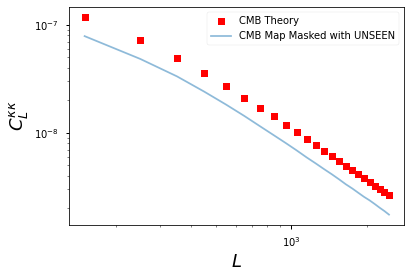

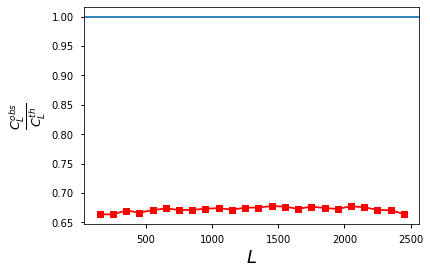

In [35]:
plot_powerspectra(cl_cmb_masked2, 'kk', label = "CMB Map Masked with UNSEEN")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


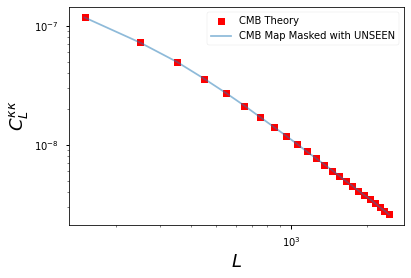

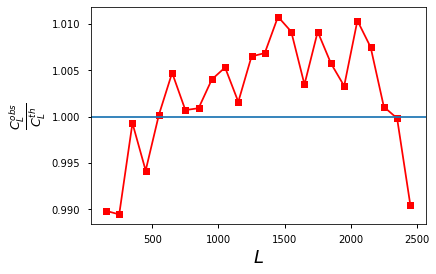

In [36]:
plot_powerspectra(cl_cmb_masked2/fsky_lensing, 'kk', label = "CMB Map Masked with UNSEEN")

***Conclusion 3: hp.UNSEEN does not affect the $\tilde{C_l}$ calculation.***

#### Test 4: Check the effect of smoothing on power spectrum recovery

We smooth the CMB Lensing map with FWHM = $5'$ (similar to Planck) and use the same random seed to generate a consistent map. 

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap.

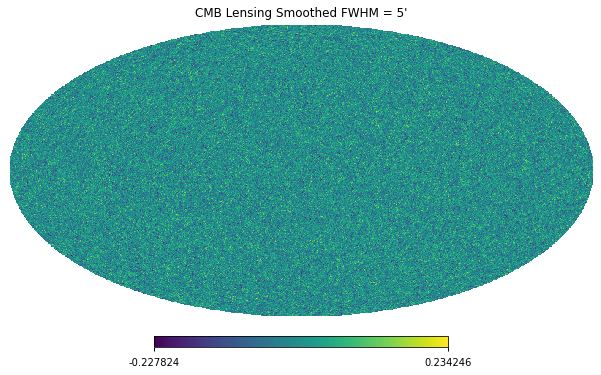

In [32]:
FWHM = 5/60 #5 arcminutes

m_k_smoothed = np.zeros(m_k.shape)
for i in tqdm(range(nmocks)):
    np.random.seed(SEED + i)
    m_k_smoothed[i] = hp.synfast(cls_cmb_th, nside=NSIDE, pol=False, fwhm=np.deg2rad(FWHM), verbose=False)

hp.mollview(m_k_smoothed[0], title = "CMB Lensing Smoothed FWHM = 5'")

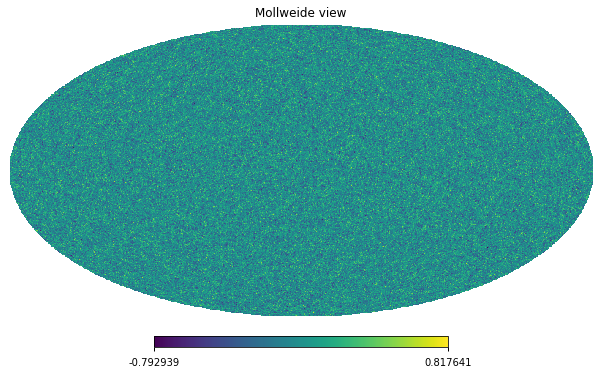

In [33]:
hp.mollview(m_g[0])

In [34]:
#Calculate pseudo-Cls

cl_cmb_smoothed = np.zeros(cl_cmb_obs.shape)
cl_cross_smoothed = np.zeros(cl_cross_obs.shape)

cL_cmb_smoothed = np.zeros((nmocks, bins.shape[0] - 1))
cL_cross_smoothed = np.zeros((nmocks, bins.shape[0] - 1))

for i in tqdm(range(nmocks)):
    cl_cmb_smoothed[i] = hp.anafast(m_k_smoothed[i], lmax = lmax-1)
    cl_cross_smoothed[i] = hp.anafast(m_g[i], m_k_smoothed[i], lmax = lmax-1)
    
    _, cL_cmb_smoothed[i] = bin_mat(ell, cl_cmb_smoothed[i], bins)
    _, cL_cross_smoothed[i] = bin_mat(ell, cl_cross_smoothed[i], bins)

100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


Text(0.5, 1.0, '$C_{\\kappa g}$')

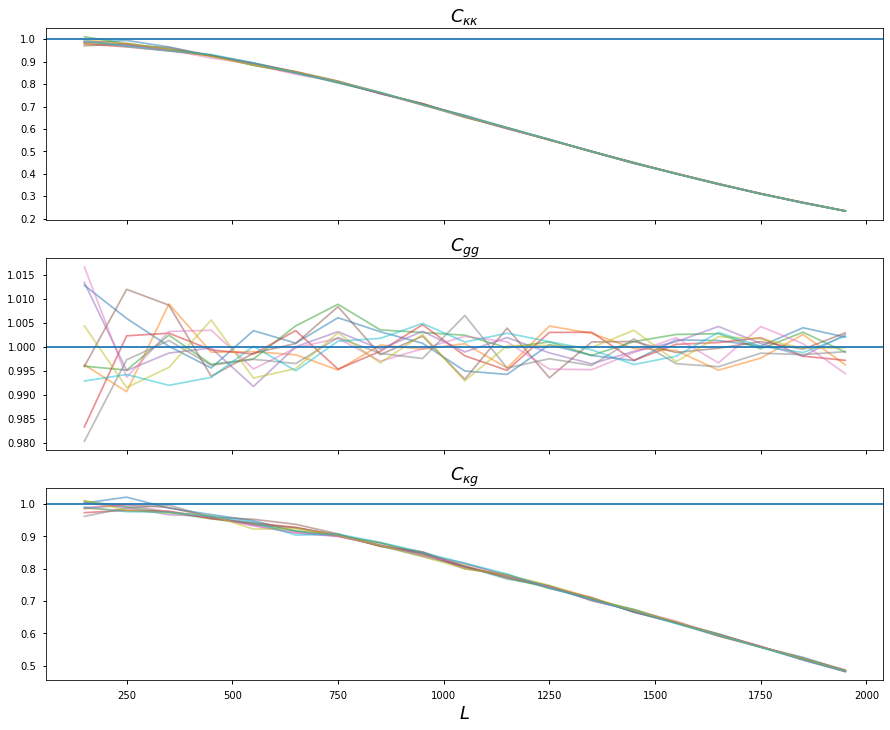

In [35]:
# Create two subplots and unpack the output array immediately
flag_clip =  ELL > 100 #choose ell modes above 100

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (15, 12))

for i in range(nmocks):
    ax1.plot(ELL[flag_clip], (cL_cmb_smoothed[i]/cLs_cmb_th)[flag_clip], alpha = 0.5)
    ax2.plot(ELL[flag_clip], (cL_elg_obs[i]/cLs_elg_th)[flag_clip], alpha = 0.5)
    ax3.plot(ELL[flag_clip], (cL_cross_smoothed[i]/cLs_cross_th)[flag_clip], alpha = 0.5)
    
ax1.axhline(1)
ax2.axhline(1)
ax3.axhline(1)
ax3.set_xlabel(r"$L$", fontsize = fs)
ax1.set_title(r"$C_{\kappa \kappa}$", fontsize = fs)
ax2.set_title(r"$C_{gg}$", fontsize = fs)
ax3.set_title(r"$C_{\kappa g}$", fontsize = fs)

We notice that beyond $l$ of few hundreds, the observed $C_l$ diverges from theory. We plot the ratio of the smoothed $C_l$ with the theory $C_l$s.

We calculate the beam function using Healpy to verify whether this divergence is due to the finite size of the beam.

In [36]:
Bl = hp.gauss_beam(fwhm=np.deg2rad(FWHM), lmax = lmax - 1)
_, BL = bin_mat(ell, Bl, bins)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Text(0.5, 1.0, '$C_{\\kappa g}$')

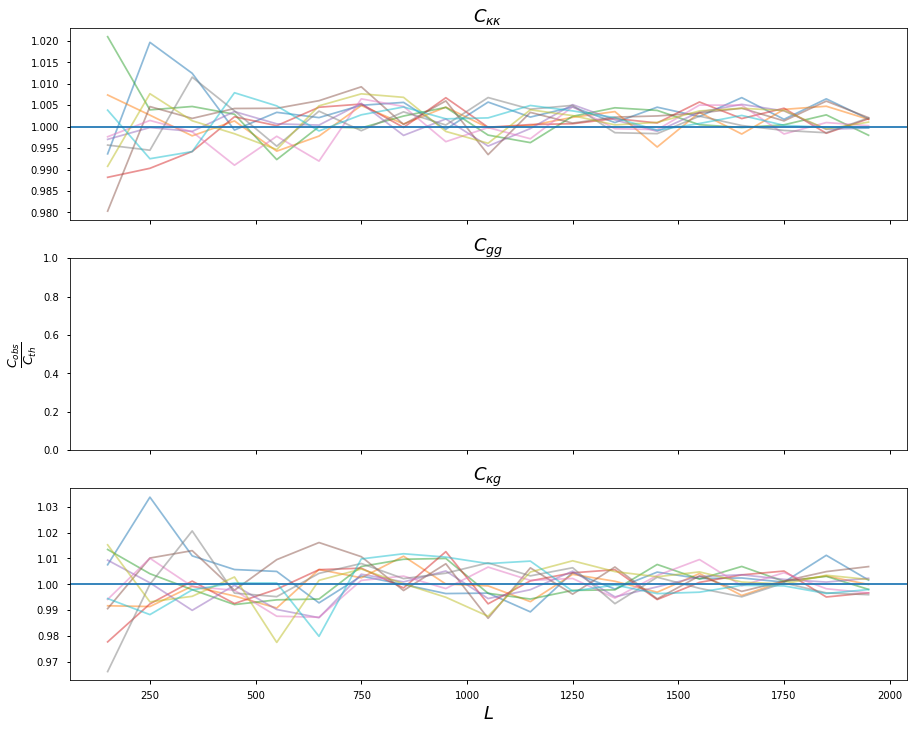

In [37]:
# Create two subplots and unpack the output array immediately
flag_clip =  ELL > 100 #choose ell modes above 100

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (15, 12))

for i in range(nmocks):
    ax1.plot(ELL[flag_clip], ((cL_cmb_smoothed[i])/BL**2/cLs_cmb_th)[flag_clip], alpha = 0.5)
    #ax1.plot(ell, Bl**2, ls = '--', c = 'k')
    #ax2.plot(ELL[flag_clip], (cL_elg_obs[i]/cLs_elg_th)[flag_clip], alpha = 0.5)
    ax3.plot(ELL[flag_clip], (cL_cross_smoothed[i]/BL/cLs_cross_th)[flag_clip], alpha = 0.5)
    #ax3.plot(ell, Bl, ls = '--', c = 'k')
    
ax1.axhline(1)
#ax2.axhline(1)
ax3.axhline(1)
ax3.set_xlabel(r"$L$", fontsize = fs)
ax2.set_ylabel(r"$\frac{C_{obs}}{C_{th}}$", fontsize = fs)
ax1.set_title(r"$C_{\kappa \kappa}$", fontsize = fs)
ax2.set_title(r"$C_{gg}$", fontsize = fs)
ax3.set_title(r"$C_{\kappa g}$", fontsize = fs)

Compare the the beam correction effect on the overall error budget

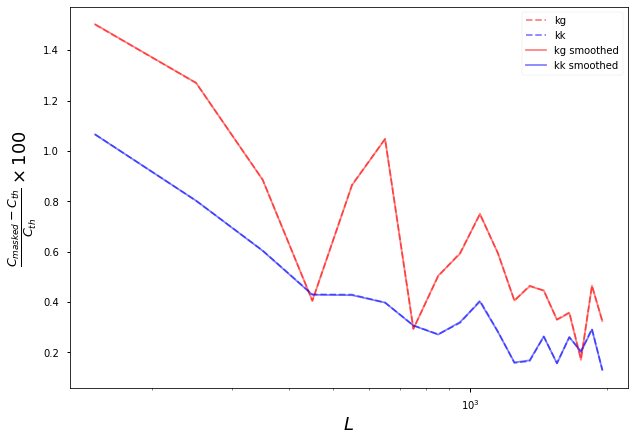

In [38]:
plt.figure(figsize=(10, 7))
plt.semilogx(ELL[flag_clip], np.std(((cL_cross_smoothed/BL) - cLs_cross_th)/cLs_cross_th * 100, axis = 0)[flag_clip], alpha = 0.5, label = 'kg', ls = '--', c = 'r')
plt.semilogx(ELL[flag_clip], np.std(((cL_cmb_smoothed/BL**2) - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip],  alpha = 0.5, label = 'kk', ls = '--', c = 'b')
#plt.semilogx(ELL[flag_clip], np.std(((cL_elg_obs) - cLs_elg_th)/cLs_elg_th * 100, axis = 0)[flag_clip], label = 'gg', ls = '--', c = 'g')

#Fourier noise only 
plt.semilogx(ELL[flag_clip], np.std((cL_cross_obs - cLs_cross_th)/cLs_cross_th * 100, axis = 0)[flag_clip], alpha = 0.5, label = 'kg smoothed', c = 'r')
plt.semilogx(ELL[flag_clip], np.std((cL_cmb_obs - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip], alpha = 0.5, label = 'kk smoothed', c = 'b')
#plt.semilogx(ELL[flag_clip], np.std((cL_elg_obs - cLs_elg_th)/cLs_elg_th * 100, axis = 0)[flag_clip], label = 'gg masked', c = 'g')

plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{masked} - C_{th}}{C_{th}} \times 100$ ", fontsize = fs)
plt.legend(loc ='best')

***Conclusion 4: After correcting for the beam function, we recover the $C_l$ value exactly. Therefore, we can account for smoothing in our pipeline.
Note: To correct for CMB Lensing, use $Bl^2$, for Lensing X ELG, use $Bl$.***

#### Test 5: Check the effect of noise on power spectrum recovery

In [39]:
nlkk = np.genfromtxt("data/MV/nlkk.dat")
ell_planck = nlkk[:,0]
Nl = nlkk[:,1]
ClplusNl = nlkk[:,2]
Cl_planck = ClplusNl - Nl

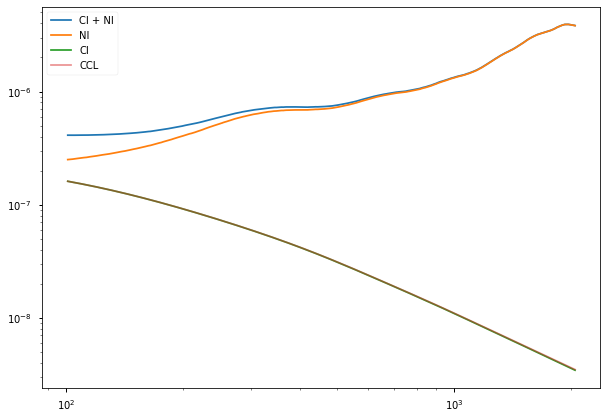

In [40]:
plt.figure(figsize=(10, 7))
plt.loglog(ell[ell > lmin], (ClplusNl[(ell_planck < lmax)])[ell > lmin], label = "Cl + Nl")
plt.loglog(ell[ell > lmin], (Nl[(ell_planck < lmax)])[ell > lmin], label = "Nl")
plt.loglog(ell[ell > lmin], ((Cl_planck)[(ell_planck < lmax)])[ell > lmin], label = "Cl")
plt.loglog(ell[ell > lmin], cls_cmb_th[ell > lmin], label = 'CCL', alpha = 0.5)
plt.legend(loc = 'best')

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Text(0.5, 1.0, 'Percentage difference between Planck $C^{\\kappa \\kappa}_l$ and CCL $C^{\\kappa \\kappa}_l$')

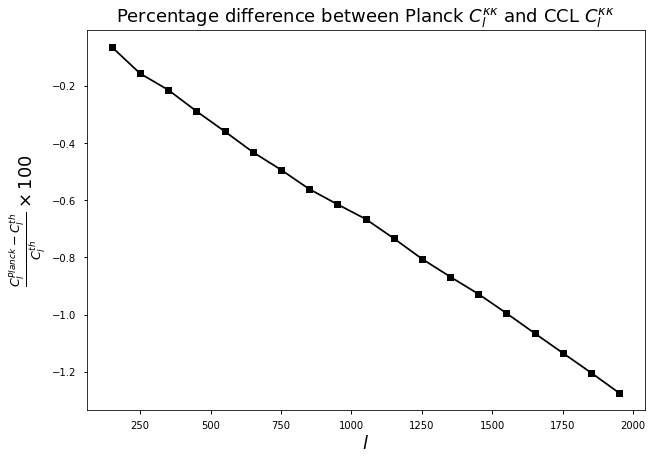

In [41]:
ELL_planck, CL_planck = bin_mat(ell_planck, Cl_planck, np.arange(0, 4096, 100))

plt.figure(figsize=(10, 7))
plt.plot(ELL[ELL > lmin], ((CL_planck[ELL_planck < lmax]/cLs_cmb_th - 1) * 100)[ELL > lmin],
         'ks', ls = '-', )
plt.ylabel(r"$\frac{C^{Planck}_{l} - C^{th}_{l}}{C^{th}_{l}} \times 100$",fontsize = fs)
plt.xlabel(r'$l$', fontsize = fs)
plt.title("Percentage difference between Planck $C^{\kappa \kappa}_l$ and CCL $C^{\kappa \kappa}_l$", fontsize = fs)

We notice that there is a clear trend as a function of $l$. The denoised $C_l$ from Planck has a systematic offset from CCL theory by $1.6\%$ at $l \sim 2500$. Note that CCL used the same fiducial cosmology as the Planck 2018 Lensing paper. 

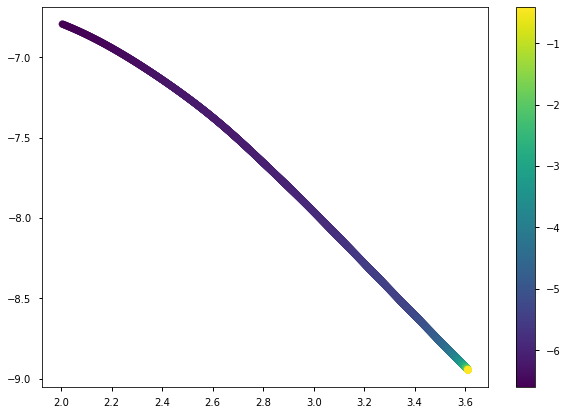

In [42]:
#plt.xscale('log')
#plt.yscale('log')
plt.figure(figsize = (10, 7))
plt.scatter(np.log10(ell_planck[ell_planck > lmin]), np.log10(Cl_planck[ell_planck > lmin]), c = np.log10(Nl[ell_planck > lmin]))
plt.colorbar()

Now we will inject noise into the signal and try to recover $C_l$:

In [46]:
m_k_noise = np.zeros(m_k.shape)

for i in tqdm(range(nmocks)):
    np.random.seed(SEED + i)
    m_k_noise[i] = hp.synfast(Nl, nside=NSIDE, pol=False, verbose = False)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

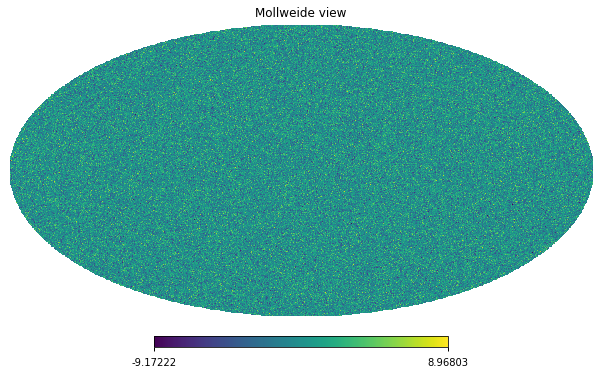

In [47]:
hp.mollview(m_k_noise[0])

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

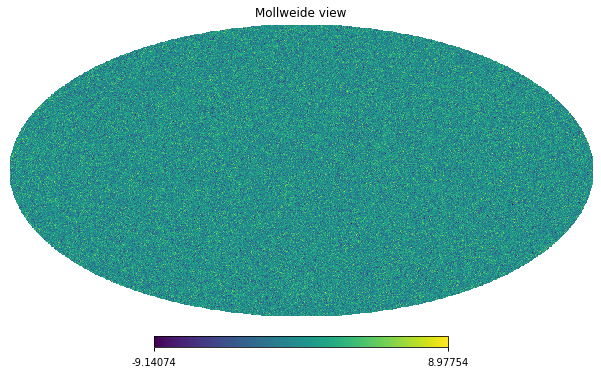

In [50]:
m_k_noised = m_k + m_k_noise
hp.mollview(m_k_noised[0])

In [51]:
#Calculate pseudo-Cls
cl_cmb_noised = np.zeros(cl_cmb_obs.shape)
cl_cmb_denoised_planck_model = np.zeros(cl_cmb_obs.shape)
cL_cmb_noised = np.zeros((nmocks, bins.shape[0] - 1))
cL_cmb_denoised_planck_model = np.zeros((nmocks, bins.shape[0] - 1))

for i in tqdm(range(nmocks)):
    cl_cmb_noised[i] = hp.anafast(m_k_noised[i], lmax = lmax - 1)
    cl_cmb_denoised_planck_model[i] = cl_cmb_noised[i] - Nl[:lmax]
    _, cL_cmb_noised[i] = bin_mat(ell, cl_cmb_noised[i], bins)
    _, cL_cmb_denoised_planck_model[i] = bin_mat(ell, cl_cmb_denoised_planck_model[i], bins)

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Text(0.5, 1.0, '$C_{\\kappa \\kappa}$ with after subtracting Planck Noise Model')

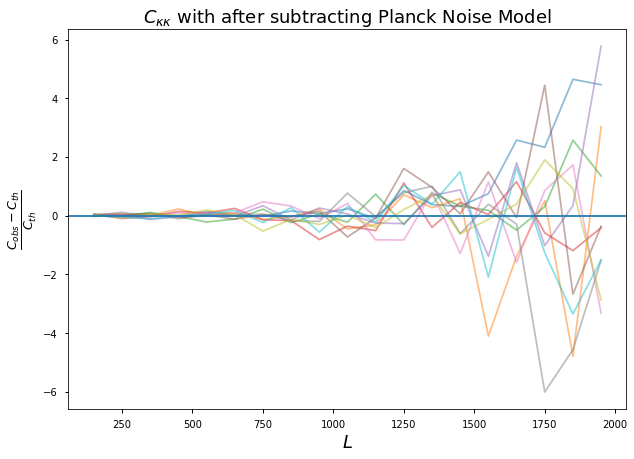

In [64]:
flag_clip =  ELL > 100 #choose ell modes above 100

#f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (15, 12))
plt.figure(figsize = (10, 7))
for i in range(nmocks):
    plt.plot(ELL[flag_clip], ((cL_cmb_denoised_planck_model[i])/cLs_cmb_th - 1)[flag_clip], alpha = 0.5)
    
plt.axhline(0)
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{obs} - C_{th}}{C_{th}}$", fontsize = fs)
plt.title(r"$C_{\kappa \kappa}$ with after subtracting Planck Noise Model", fontsize = fs)

In [68]:
np.std((np.mean(cL_cmb_denoised_planck_model, axis = 0) - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)

27.404883480697837

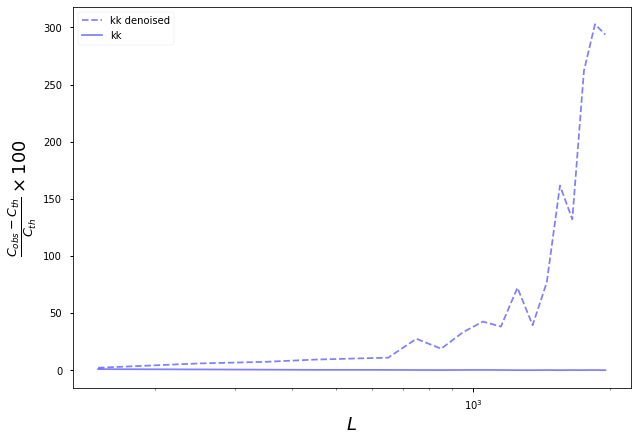

In [71]:
plt.figure(figsize=(10, 7))
plt.semilogx(ELL[flag_clip], np.std((cL_cmb_denoised_planck_model - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip],  alpha = 0.5, label = 'kk denoised', ls = '--', c = 'b')

#Fourier noise only 
plt.semilogx(ELL[flag_clip], np.std((cL_cmb_obs - cLs_cmb_th)/cLs_cmb_th * 100, axis = 0)[flag_clip], alpha = 0.5, label = 'kk', c = 'b')

plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C_{obs} - C_{th}}{C_{th}} \times 100$ ", fontsize = fs)
plt.legend(loc ='best')

Compare $C_l$ from healpix with Planck model

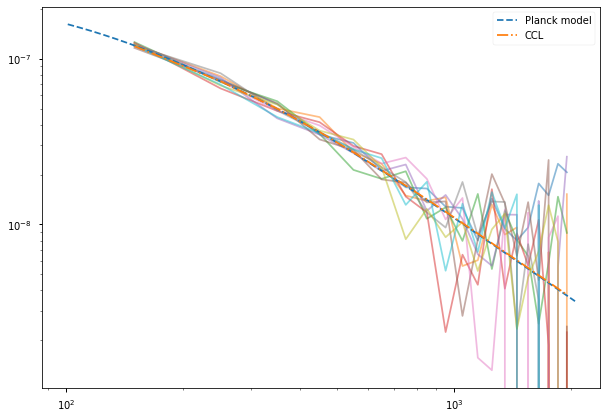

In [72]:
plt.figure(figsize = (10, 7))

flag_clip =  ELL > 100 #choose ell modes above 100

for i in range(nmocks):
    plt.loglog(ELL[flag_clip], (cL_cmb_denoised_planck_model[i])[flag_clip], alpha = 0.5)
    
plt.loglog(ell_planck[(ell_planck > lmin) & (ell_planck < lmax)], Cl_planck[(ell_planck > lmin) & (ell_planck < lmax)], ls = '--', label = 'Planck model')
plt.loglog(ELL[flag_clip], cLs_cmb_th[flag_clip], ls = '-.', label = 'CCL')
plt.legend(loc = 'best')

### ***Conclusion 5: Entirely noise dominated. 5% Error around $l \sim 1000$***

#### Test 6: Create map with mask, noise and smoothening and recover $C_l$s

Procedure:
- Add noise
- Smoothen
- Add mask 
- Same for ELG map

In [140]:
#first generate noise map with FWHM and mask 
np.random.seed(SEED)
noise_map_smooth = hp.synfast(N_l, nside=NSIDE, pol = False, fwhm=np.deg2rad(FWHM))
m_k_noise_full = hp.ma(noise_map_smooth, badval = 0)
m_k_noise_full.mask = np.logical_not(lensingMask_planck)

#generate signal map with FWHM and mask
m_k_signal_full = hp.ma(m_k_smoothed, badval = 0)
m_k_signal_full.mask = np.logical_not(lensingMask_planck)

#add two maps
m_k_full = m_k_noise_full + m_k_signal_full

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin


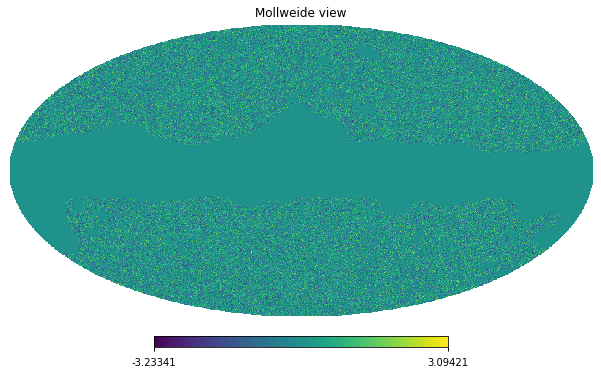

In [141]:
hp.mollview(m_k_full)

In [142]:
cl_cmb_full = hp.anafast(m_k_full, lmax = lmax - 1)

#correct  for masking, i.e. fsky
cl_cmb_full /= fsky_lensing

#correct for smoothing, i.e. beam
cl_cmb_full /= beam**2

#correct for noise 
cl_cmb_full -= N_l[:lmax]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


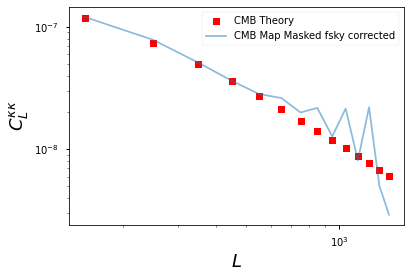

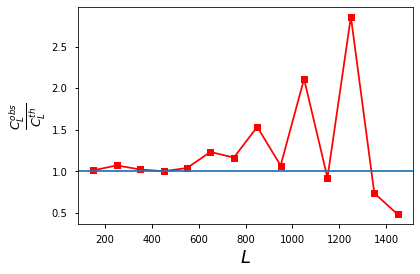

In [143]:
plot_powerspectra(cl_cmb_full, 'kk', label = "CMB Map Masked fsky corrected", ELL_max=1500)

It appears that the combined effect is significant enough on the $C_l$ measurement, even after applying individual corrections. 

Create noisy, masked, smoothen map for ELGs and calculate cross $C_l$

In [133]:
#add shot noise to ELGs
density_deg2 = 2400
deg2_to_sr = 3.046e-4 #1 deg2 = 3.046e-4 sr
density_sr = density_deg2/deg2_to_sr
shot_noise_sr = 1/density_sr
shot_noise_sr

1.2691666666666666e-07

In [145]:
#first generate noise map with FWHM and mask 
np.random.seed(SEED)
noise_map_elg = hp.synfast(shot_noise_sr * np.ones(m_g.shape[0]), nside = NSIDE,\
                pol = False, fwhm = np.deg2rad(FWHM))
m_g_noise_full = hp.ma(noise_map_elg, badval = 0)
m_g_noise_full.mask = np.logical_not(elg_mask)

#generate signal map with FWHM and mask
np.random.seed(SEED)
m_g_smoothed = hp.synfast(cls_elg_th, nside=NSIDE, pol=False, fwhm=np.deg2rad(FWHM))
m_g_signal_full = hp.ma(m_g_smoothed, badval = 0)
m_g_signal_full.mask = np.logical_not(elg_mask)

#add two maps
m_g_full = m_g_noise_full + m_g_signal_full

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin
Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin


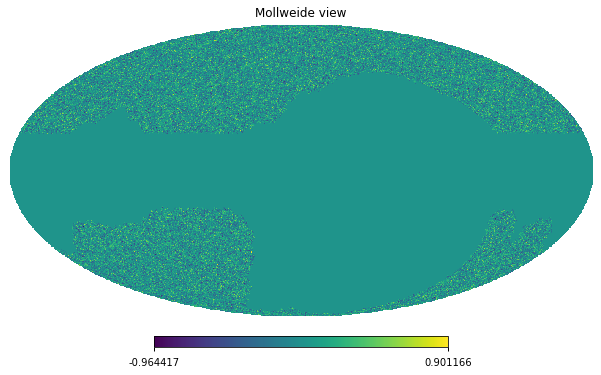

In [146]:
hp.mollview(m_g_full)

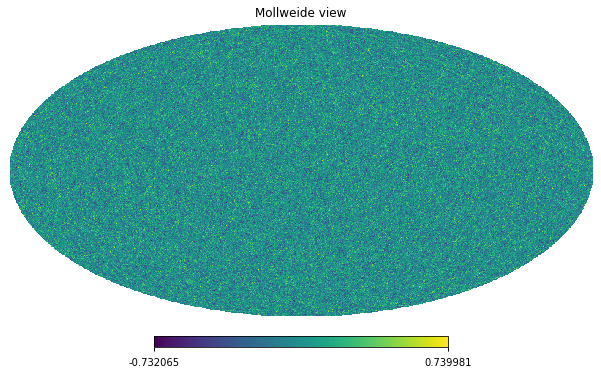

In [152]:
hp.mollview(m_g)

In [151]:
#calculate cross C_l
cl_cross_full = hp.anafast(m_k_full, m_g_full, lmax = lmax - 1)

#correct  for masking, i.e. fsky
cl_cross_full /= fsky_cross

#correct for smoothing, i.e. beam
cl_cross_full /= beam

#correct for noise 
#cl_cmb_full -= N_l[:lmax]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


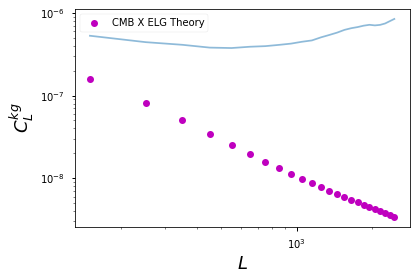

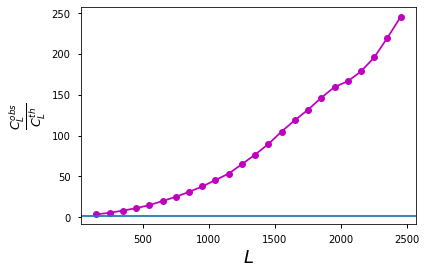

In [150]:
plot_powerspectra(cl_cross_full, 'kg')

#### Metric 1: RCC

\begin{equation}
RCC_{l} = \frac{C^{\kappa g}_{l}}{\sqrt{C^{m m}_{l} C^{gg}_{l}}}
\end{equation}

If $\kappa$ is replaced by $m$, then $RCC = 1$ for systematic-free measurement as it is linear bias independent. Any noticeable deviation from $RCC = 1$ indicates systematics. Here, we calculate what $RCC_{l}$ should be from theory so we can compare observed $RCC$ against this. 

Text(0, 0.5, 'RCC')

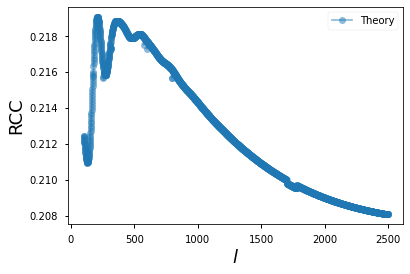

In [17]:
RCC_th = cls_cross_th/np.sqrt(cls_mm_th * cls_elg_th)
#RCC_obs = (cl_cross_masked/fsky_cross)/np.sqrt((cl_cmb_masked/fsky_lensing) * (cl_elg_masked/fsky_elg))
plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Theory", alpha = alpha, marker = "o")
#plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Observed", alpha = .1, marker = "*")
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel("RCC", fontsize = fs)

***Observation 1: RCC metric is highly non-linear and not a constant of $1$ as a function of $l$.***

***Conclusion 4: RCC can be recovered almost exactly after correcting for $f_{sky}$.***

## Section 2: Running MCMC Inference 

In this section, we construct an analytic covariance matrix and a script to do cosmological inferences. 

#### Analytic Covariance Matrix

First we bin the data in bins of $100 l$:

In [202]:
#binned Cls by L = 100l
%time _, cL_cross_obs = bin_mat(ell, cl_cross_obs, bins)

CPU times: user 20.8 ms, sys: 12 µs, total: 20.9 ms
Wall time: 19.6 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We will use analytic formulation of the covariance matrix for full-sky coverage assuming no noise:

\begin{equation}
\sigma^{2}_{C^{\kappa g}_{l}} = \frac{1}{\left( 2l + 1 \right) f_{sky}} \left[ \left( C^{\kappa g}_{l} \right)^2  + C^{\kappa \kappa}_{l} C^{gg}_{l} \right]
\end{equation}

In [203]:
covCls = 1/fsky_cross * np.diag(1/(2 * ell + 1) * ((cls_cross_th)**2 + cls_cmb_th * cls_elg_th))
_, covCls_binned = bin_mat(ell, covCls, bins)
error = np.sqrt(np.diag(covCls_binned))
#ivarCls = np.linalg.inv(covCls)
ivarCls_binned = np.linalg.inv(covCls_binned) 

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


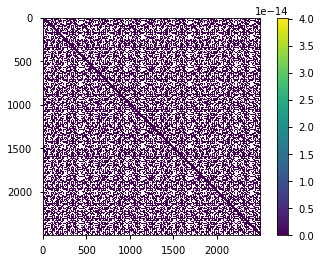

In [204]:
plt.imshow(covCls, vmax = 4.02e-14, vmin = 0.)
plt.colorbar()

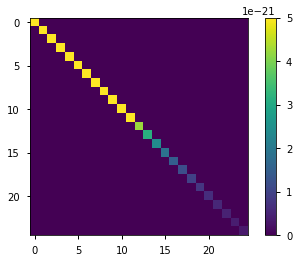

In [205]:
plt.imshow(covCls_binned, vmax = 5e-21, vmin = 0.)
plt.colorbar()

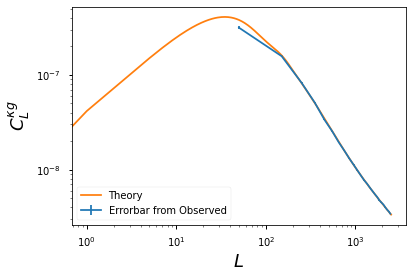

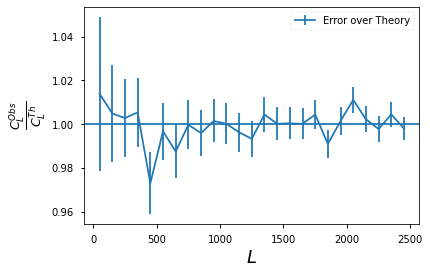

In [53]:
plt.errorbar(ELL, cL_cross_obs, error, label = "Errorbar from Observed")
plt.loglog(ell, cls_cross_th, label = "Theory")
plt.ylabel(r"$C^{\kappa g}_{L}$", fontsize = fs)
plt.xlabel(r"$L$", fontsize = fs)
plt.legend(loc = 'best')
plt.show()
plt.errorbar(ELL, cL_cross_obs/cLs_cross_th, error/cLs_cross_th,
            label = "Error over Theory")
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C^{Obs}_{L}}{C^{Th}_{L}}$", fontsize = fs)
plt.axhline(1)
plt.legend(loc = 'best')

We will do inference on two parameters, $\theta$ = [$\Omega_c, \sigma_8$].

In [54]:
import emcee
import corner

In [55]:
#define loglikelihood
#def loglike(theta, data = cl_cross_obs, ivar = ivarCls):
def loglike(theta):
    cosmo = ccl.Cosmology(Omega_c = theta[0], Omega_b = 0.049,
        h = 0.670, n_s = 0.964, sigma8 = theta[1],
        m_nu_type='list', m_nu = np.array([0, 0, 0.06]),
        transfer_function='boltzmann_camb')
        
    cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
    elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    model = ccl.angular_cl(cosmo, cmbl, elgl, ell)
    
    _, model_binned = bin_mat(ell, model, bins)
#     diff = cl_cross_obs - model
    diff = cL_cross_obs - model_binned
    
    return -0.5 * (diff).T @ ivarCls_binned @ diff

In [56]:
#utils functions 
def mcmc(loglikelihood, init_pos, nsamples, thread):
    """Returns emcee sampler based on log likelihood,
    initial position and number of walkers."""
    
    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    #initiate sampler and run
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikelihood, threads=thread)
    sampler.run_mcmc(p0, nsamples, progress=True);
    
    return sampler

def trace_autocorr(sampler, labels):
    """Returns traceplots and autocorrelation time
    of parameters based on emcee chain output.
    
    Parameters
    ----------
    samples : sampler.get_chain() output from emcee
    labels : names of parameters 
    """
    
    samples = sampler.get_chain()
    ndim = samples.shape[2]
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize = 15)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    #check auto-correlation time
    tau = sampler.get_autocorr_time()
    print(tau)
    
def burn_thin(sampler,  burn_in, thinning):
    """Returns flattened chains after burn-in and thinning."""
    
    flat_samples = sampler.get_chain(discard=burn_in, thin=thinning,
                    flat=True)
    return flat_samples

def cornerplot(flat_samples, **kwargs):
    figure = corner.corner(flat_samples, **kwargs)

In [57]:
#setup walkers
nwalkers = 10; ndim = 2
np.random.seed(24)
p0 = np.random.multivariate_normal(mean = np.array([0.268, 0.812]), 
                                cov = np.array([[0.00001, 0], [0, 0.00001]]), 
                              size = nwalkers)

In [58]:
def mcmc_parallel(loglikelihood, init_pos, nsamples):

    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, loglikelihood, pool=pool)
        #start = time.time()
        sampler.run_mcmc(p0, nsamples, progress=True);
        #end = time.time()
        #multi_data_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_data_time))
        #print(
        #    "{0:.1f} times faster(?) than serial".format(serial_data_time / multi_data_time)
        #)

In [59]:
%time loglike(p0[0]+.2)

/home/tanveer/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


CPU times: user 3.28 s, sys: 4.68 ms, total: 3.29 s
Wall time: 742 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


-481276.1301909711

In [60]:
#run sampler
%time sampler = mcmc(loglikelihood=loglike, init_pos=p0, nsamples=1000, thread = 8)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████| 1000/1000 [2:21:13<00:00,  8.47s/it] 

CPU times: user 10h 30min 7s, sys: 32.3 s, total: 10h 30min 39s
Wall time: 2h 21min 22s


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [26.56457809 27.08956068]

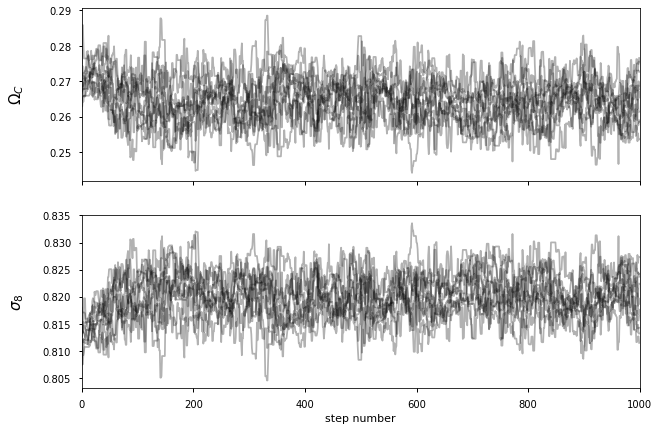

In [61]:
trace_autocorr(sampler, [r"$\Omega_C$", "$\sigma_8$"])

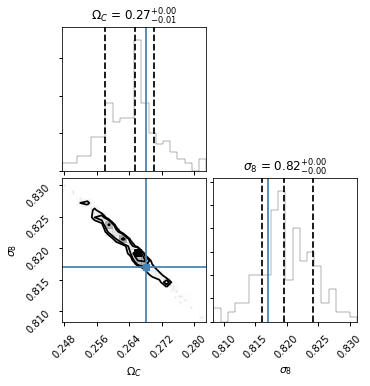

In [63]:
#burn-in and thinning
flat_samples = burn_thin(sampler, 100, 50)

#cornerplot
cornerplot(flat_samples, labels = [r"$\Omega_C$", "$\sigma_8$"],
        quantiles=np.array([.16, .5, .84]), truths=np.array([0.268, 0.817]),
        show_titles=True, title_kwargs={"fontsize": 12})

Test MCMC without neutrino:

In [64]:
def loglike2(theta):
    cosmo = ccl.Cosmology(Omega_c = theta[0], Omega_b = 0.049,
        h = 0.670, n_s = 0.964, sigma8=theta[1],
        transfer_function='boltzmann_camb')
        
    cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
    elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    model = ccl.angular_cl(cosmo, cmbl, elgl, ell)
    
    _, model_binned = bin_mat(ell, model, bins)
#     diff = cl_cross_obs - model
    diff = cL_cross_obs - model_binned
    
    return -0.5 * (diff).T @ ivarCls_binned @ diff

In [65]:
%time loglike2(p0[0]+.2)

CPU times: user 2.03 s, sys: 0 ns, total: 2.03 s
Wall time: 423 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


-479777.27819864085

In [66]:
#run sampler
%time sampler_no_neutrino = mcmc(loglikelihood=loglike2, init_pos=p0, nsamples=1000, thread = 8)

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
100%|██████████| 1000/1000 [1:21:11<00:00,  4.87s/it]

CPU times: user 6h 36min 49s, sys: 25.7 s, total: 6h 37min 14s
Wall time: 1h 21min 16s


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.49877427 24.36896475]

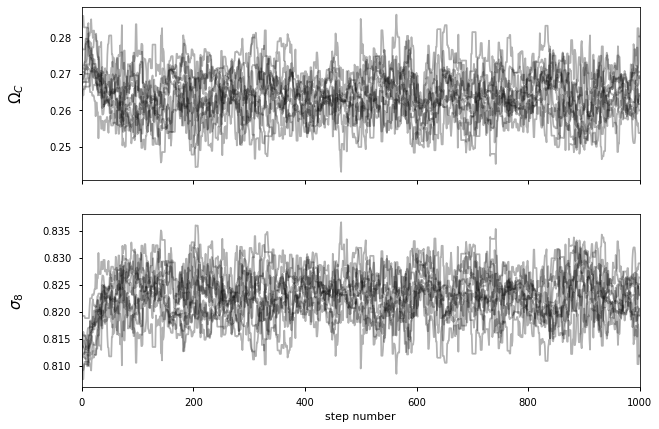

In [67]:
trace_autocorr(sampler_no_neutrino, [r"$\Omega_C$", "$\sigma_8$"])

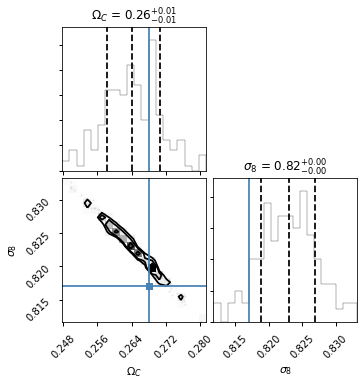

In [69]:
#burn-in and thinning
flat_samples_no_neutrino = burn_thin(sampler_no_neutrino, 100, 50)

#cornerplot
cornerplot(flat_samples_no_neutrino, labels = [r"$\Omega_C$", "$\sigma_8$"],
        quantiles=np.array([.16, .5, .84]), truths=np.array([0.268, 0.817]),
        show_titles=True, title_kwargs={"fontsize": 12})

In [64]:
flat_samples.shape

(0, 2)

Observations:
- The sampler takes an unusually long amount of time to run. Each iteration takes roughly $7.5$ seconds to compute which makes this procedure very expensive, even for two parameters. 
- The autocorrelation time diagnostic suggests that 1000 points are not enough and we need to run the chain longer. However, with each iteration taking $7.5$ seconds, this becomes a very expensive procedure. 
- The final result is nowhere near the truth. Even with $0$ noise and full-sky signal, the inferred $\Omega_{C}$ is really off, and the $\sigma_{8}$ measurement is somewhat off. 

## Section 3: Jack-knife region

First visualize the full mask (combining Planck and DR8 masks):

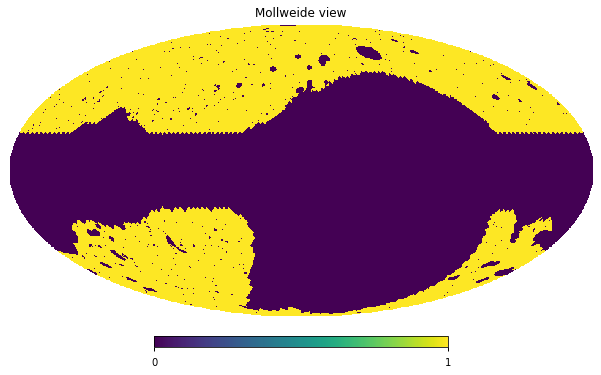

In [53]:
hp.mollview(cross_mask)

In [55]:
"""Produces jackknifes based on map based on Sukhdeep's code"""
def gal_jk(mask=[],dat=[],nside=512,njk1=5,njk2=20,nest=False,frame_in='galactic',frame_use='galactic'):    
    #mask2=rotate_mask(mask=mask,nside=nside,nest=nest,frame_in=frame_in,frame_out=frame_use)
    mask2 = mask
    njk=njk1 #np.sqrt(njk_tot)                                                                                                                                       
    x=mask2>0                                                                                                                                                        
    nii=np.int64(sum(x)/njk+1)                                                                                                                                       
                                                                                                                                                                     
    jkmap=np.zeros_like(mask2,dtype='float64')-999                                                                                                                   
    ii=np.int64(np.arange(len(mask2)))                                                                                                                               
    ii=ii[x]                                                                                                                                                         
    for i in np.int64(np.arange(njk)):                                                                                                                               
        if (i == (nii%njk)):  #Why this step?                                                                                                                                           
            nii-=1                                                                                                                                                    
        indx=ii[i*nii:(i+1)*nii]                                                                                                                                     
        jkmap[indx]=i                                                                                                                                                
                                                                                                                                                                     
    #njk2=njk_tot/njk                                                                                                                                                
    jkmap2=np.zeros_like(jkmap)-999                                                                                                                                  
    ii=np.int64(np.arange(len(jkmap2)))                                                                                                                              
    for i in np.int64(np.arange(njk)):                                                                                                                               
        x=(jkmap==i)                                                                                                                                                   
        ii2=ii[x]                                                                                                                                                    
        add_f=0                                                                                                                                                      
        if i==0:#to get circle at galactic pole                                                                                                                      
            nii=np.int64(sum(x)/njk2)                                                                                                                                
            jkmap2[ii2[:nii]]=0                                                                                                                                      
            ii2=ii2[nii:]                                                                                                                                            
            add_f=1                                                                                                                                                  
        theta,phi=hp.pixelfunc.pix2ang(nside,ii2,nest=nest)                                                                                                          
        phi_bins=np.percentile(phi,np.linspace(0,100,njk2+1-add_f))                                                                                                  
        phi_bins[0]-=0.1                                                                                                                                             
        phi_bins[-1]+=0.1                                                                                                                                            
        for j in np.int64(np.arange(njk2-add_f)):                                                                                                                    
            xphi=phi>phi_bins[j]                                                                                                                                     
            xphi*=phi<phi_bins[j+1]                                                                                                                                  
            indx=ii2[xphi]                                                                                                                                           
            jkmap2[indx]=i*njk2+j+add_f                                                                                                                              
                                                                                                                                                                     
    #c = ICRS(ra=dat['RA']*units.degree, dec=dat['DEC']*units.degree)#,unit=(units.degree, units.degree))                                                            
    #dat_galactic=c.transform_to(Galactic)                                                                                                                           
    """c=SkyCoord(ra=dat['RA']*units.degree, dec=dat['DEC']*units.degree,frame='icrs')   
    if frame_use=='icrs':
        gpix=hp.pixelfunc.ang2pix(nside=nside,nest=False,theta=c.dec.radian*-1+np.pi/2.,                                                                         
                              phi=c.ra.radian)           
    elif frame_use=='galactic':
        dat_galactic=c.galactic                                                                                                                                          
        gpix=hp.pixelfunc.ang2pix(nside=nside,nest=nest,theta=dat_galactic.b.radian*-1+np.pi/2.,                                                                         
                                  phi=dat_galactic.l.radian)"""
    
    #jkgal=jkmap2[gpix]
    #njk=np.int(njk1*njk2)
    #jkgal=Table(array(jkgal,dtype=[('jk'+str(njk),'int32')]))
    #return jkgal                             
    return jkmap2

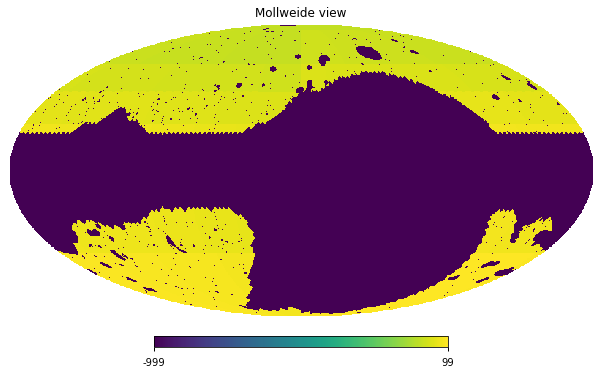

In [126]:
#Run and visualize jackknifed regions
jkg = gal_jk(mask = cross_mask, dat = ranCat, nside = NSIDE)
hp.mollview(jkg)

In [127]:
#RA and DEC of good pixels 
ra, dec = hp.pix2ang(nside = NSIDE, ipix = idx_good, lonlat = True)

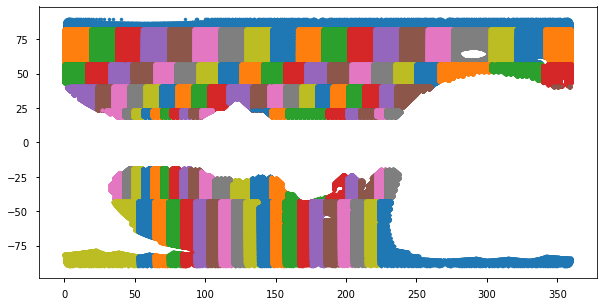

<Figure size 432x288 with 0 Axes>

In [128]:
import seaborn as sns
njk=100 #number of jack-knifed regions
c=sns.color_palette()[:-1]

plt.figure(figsize = (10, 5))
for i in np.arange(njk):
    xx=(jkg[cross_mask]==i) #scatter plot relevant regions with the same color
    a=plt.scatter(ra[xx], dec[xx], color = c[i%len(c)], s=10)

plt.show()
plt.savefig("plots/DESI_Planck_Jackknife.png", dpi = 200, bbox_inches = 'tight')

In [161]:
#Code to run Jackknife for C_l. 
cl_jk = np.zeros((njk, lmax))

for i in np.arange(njk):
    
    #create jackknife mask along with regular mask
    tmpmask = np.copy(cross_mask)
    tmpmask[np.arange(len(tmpmask))[jkg == i]] = 0 #select indices of jackknife region and set to 0
    
    #impose jackknife mask along with regular mask
    map_obs = np.copy(m_g)
    map_obs[tmpmask == 0] = 0

    #calculate C_l
    cl_jk[i] = hp.anafast(map_obs, lmax = lmax - 1) 

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [177]:
cl_mean=np.mean(cl_jk,axis=0) 
cl_cov=np.cov(cl_jk, rowvar=0) 
cl_cov *= (njk-1)*(njk-1)/njk 

In [178]:
cl_cov.shape

(2500, 2500)

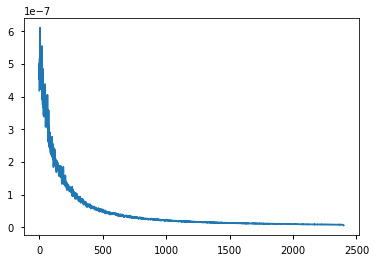

In [180]:
plt.plot(cl_mean[lmin:lmax])

Compare covariance matrix with theory

In [208]:
np.diag(covCls)

array([0.00000000e+00, 1.22336768e-14, 1.99618741e-14, ...,
       3.20490325e-20, 3.20019005e-20, 3.19548566e-20])

In [209]:
np.diag(cl_cov)

array([6.28832762e-15, 1.40925771e-13, 4.68172558e-14, ...,
       3.35760018e-20, 3.52160398e-20, 1.72491440e-20])